Importing some libraries and setting the plot style.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

Reading in the data from the csv files provided on Kaggle.
Pandas is python's data analysis library, which makes it much easier to work with the data.

In [2]:
# we will skip 2001 - 2005 due to bad quality

crimes1 = pd.read_csv('../input/Chicago_Crimes_2005_to_2007.csv',error_bad_lines=False)
crimes2 = pd.read_csv('../input/Chicago_Crimes_2008_to_2011.csv',error_bad_lines=False)
train = pd.concat([crimes1, crimes2], ignore_index=False, axis=0)
test = pd.read_csv('../input/Chicago_Crimes_2012_to_2017.csv',error_bad_lines=False)

del crimes1
del crimes2

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


Start by dropping the duplicate entries, if there are any. We also prent out the dimensions of the table, and see
that indeed there was duplicate data.

In [3]:
print('Dataset Shape before drop_duplicate : ', train.shape)
train.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
print('Dataset Shape after drop_duplicate: ', train.shape)

Dataset Shape before drop_duplicate :  (4561053, 23)
Dataset Shape after drop_duplicate:  (2879842, 23)


Next, we delete entries that we don't feel are necessary for doing our analysis.
We removed the Case Number as that is unique to each case and doesn't contribute anything.

We also delete the IUCR which are codes used to describe the crime that occurred. We have enough info from the Primary Type and
Description fields. 

We also got rid of the X and Y coordinates since they provided the Longitude and Latitudes of where the crimes occurred.

In [4]:
train.drop(['Unnamed: 0', 'ID', 'Case Number', 'Updated On', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'Latitude', 'Longitude'], inplace=True, axis=1)

#Let's have a look at the first 3 records and see if we see what we expect
train.head(3)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Latitude,Longitude
0,4673626,04/02/2006 01:00:00 PM,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,41.981913,-87.771996
1,4673627,02/26/2006 01:40:48 PM,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,41.775733,-87.611920
2,4673628,01/08/2006 11:16:00 PM,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,41.769897,-87.593671


In [5]:
# convert dates to pandas datetime format
train.Date = pd.to_datetime(train.Date, format='%m/%d/%Y %I:%M:%S %p')
# setting the index to be the date will help us a lot later on
train.index = pd.DatetimeIndex(train.Date)

In [6]:
# of records X # of features
train.shape

(4336556, 10)

In [7]:
train.info()

loc_to_change  = list(train['Location Description'].value_counts()[20:].index)
desc_to_change = list(train['Description'].value_counts()[20:].index)
#type_to_change = list(crimes['Primary Type'].value_counts()[20:].index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4336556 entries, 2006-04-02 13:00:00 to 2016-05-03 23:38:00
Data columns (total 10 columns):
ID                      int64
Date                    datetime64[ns]
Block                   object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Latitude                float64
Longitude               float64
dtypes: bool(2), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 306.0+ MB


In [8]:
train.loc[train['Location Description'].isin(loc_to_change) , train.columns=='Location Description'] = 'OTHER'
train.loc[train['Description'].isin(desc_to_change) , train.columns=='Description'] = 'OTHER'
#crimes.loc[crimes['Primary Type'].isin(type_to_change) , crimes.columns=='Primary Type'] = 'OTHER'

# we convert those 3 columns into 'Categorical' types -- works like 'factor' in R
train['Primary Type']         = pd.Categorical(train['Primary Type'])
train['Location Description'] = pd.Categorical(train['Location Description'])
train['Description']          = pd.Categorical(train['Description'])

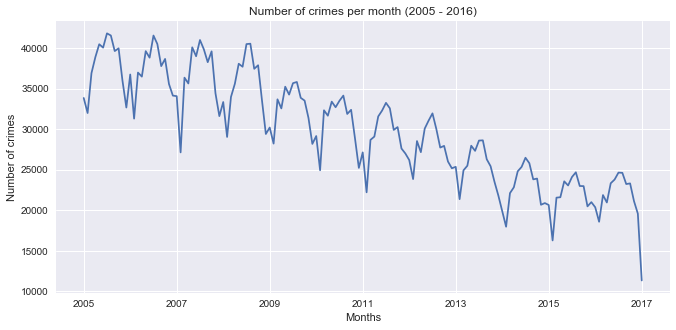

In [9]:
plt.figure(figsize=(11,5))
train.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2005 - 2016)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

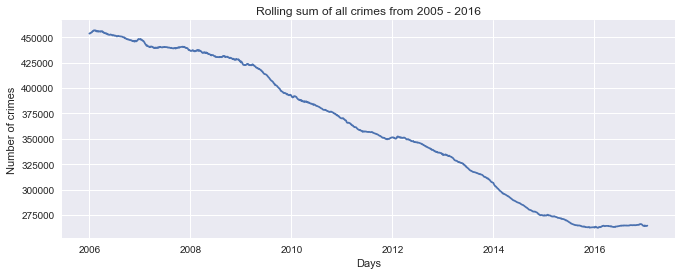

In [10]:
plt.figure(figsize=(11,4))
train.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2005 - 2016')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

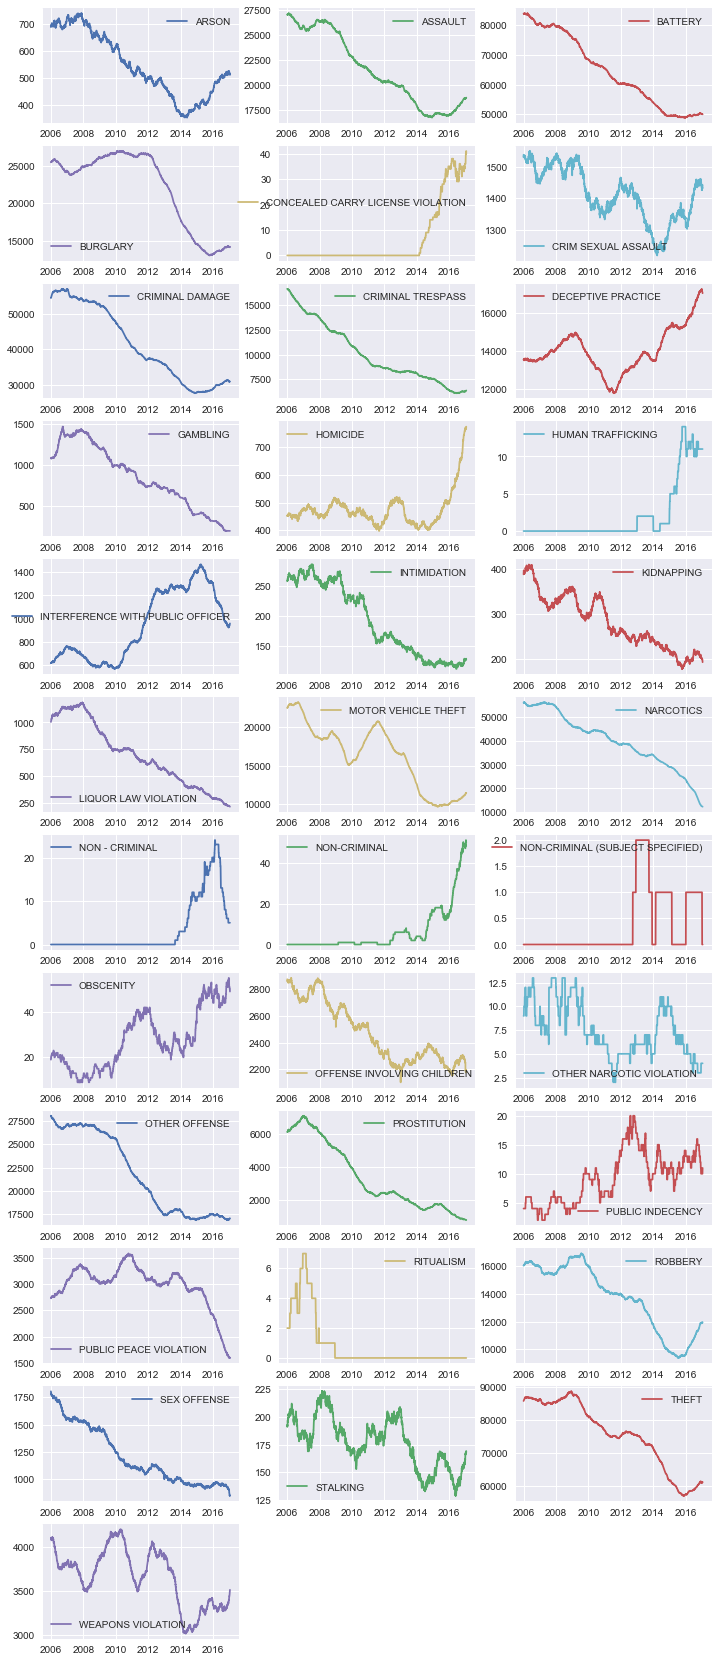

In [11]:
crimes_count_date = train.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=train.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
train.groupby([train.index.dayofweek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

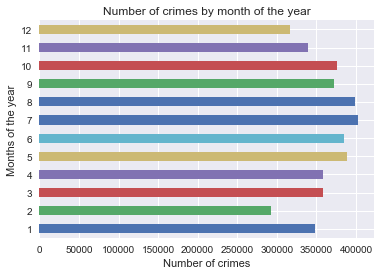

In [12]:
train.groupby([train.index.month]).size().plot(kind='barh')
plt.ylabel('Months of the year')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by month of the year')
plt.show()

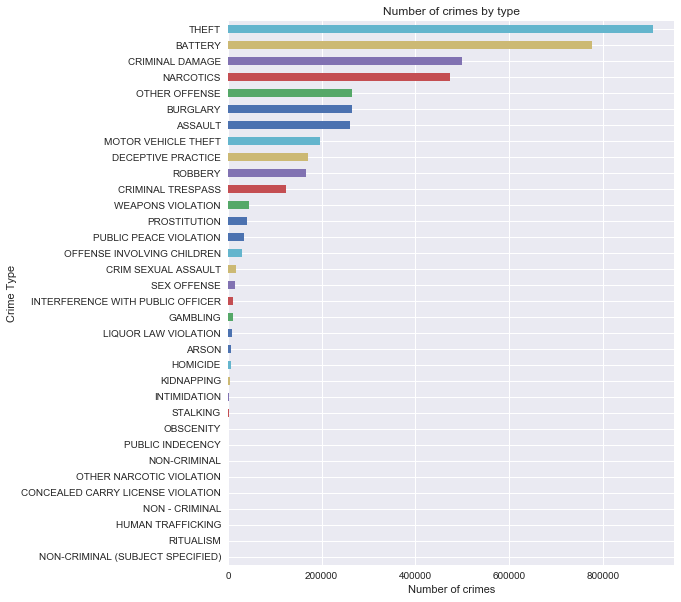

In [13]:
plt.figure(figsize=(8,10))
train.groupby([train['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

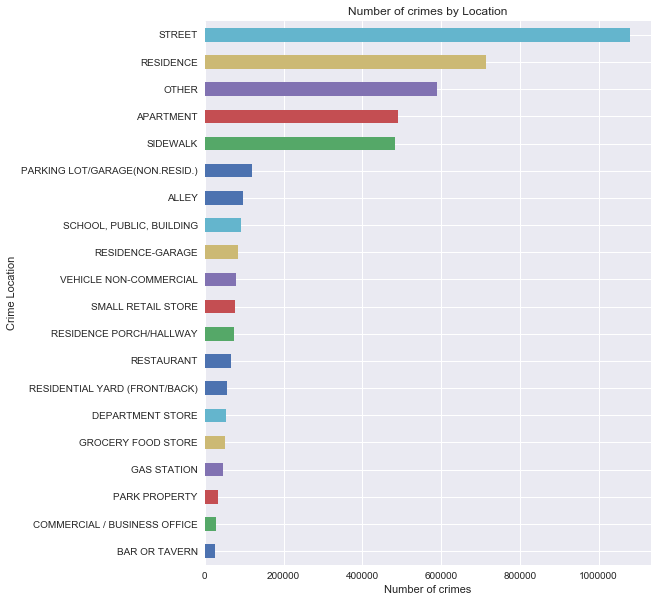

In [14]:
plt.figure(figsize=(8,10))
train.groupby([train['Location Description']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Location')
plt.ylabel('Crime Location')
plt.xlabel('Number of crimes')
plt.show()

In [15]:
hour_by_location = train.pivot_table(values='ID', index='Location Description', columns=train.index.hour, aggfunc=np.size).fillna(0)
hour_by_type     = train.pivot_table(values='ID', index='Primary Type', columns=train.index.hour, aggfunc=np.size).fillna(0)
hour_by_week     = train.pivot_table(values='ID', index=crimes.index.hour, columns=train.index.weekday_name, aggfunc=np.size).fillna(0)
hour_by_week     = hour_by_week[days].T # just reorder columns according to the the order of days
dayofweek_by_location = train.pivot_table(values='ID', index='Location Description', columns=train.index.dayofweek, aggfunc=np.size).fillna(0)
dayofweek_by_type = train.pivot_table(values='ID', index='Primary Type', columns=train.index.dayofweek, aggfunc=np.size).fillna(0)
location_by_type  = train.pivot_table(values='ID', index='Location Description', columns='Primary Type', aggfunc=np.size).fillna(0)

In [16]:
from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)
    
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

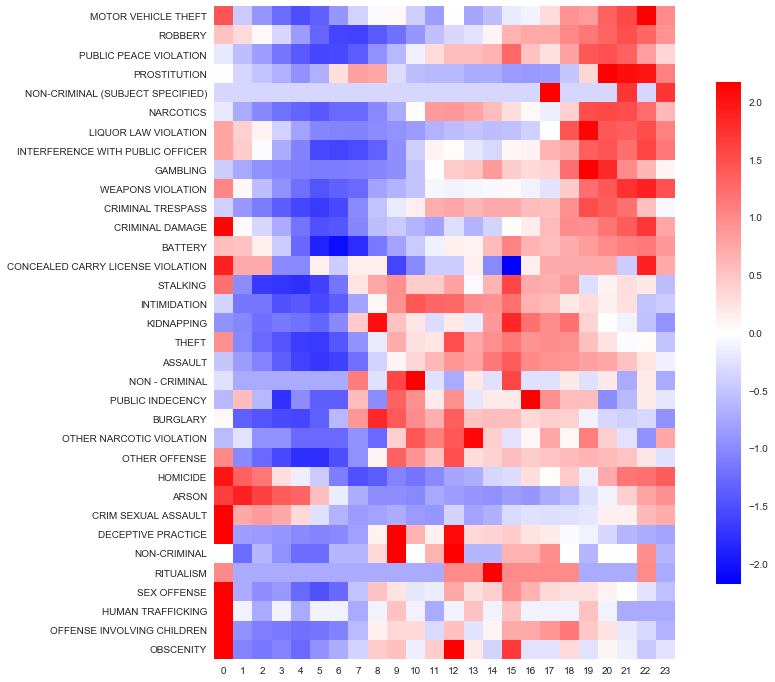

In [17]:
plt.figure(figsize=(15,12))
scale_and_plot(hour_by_type)


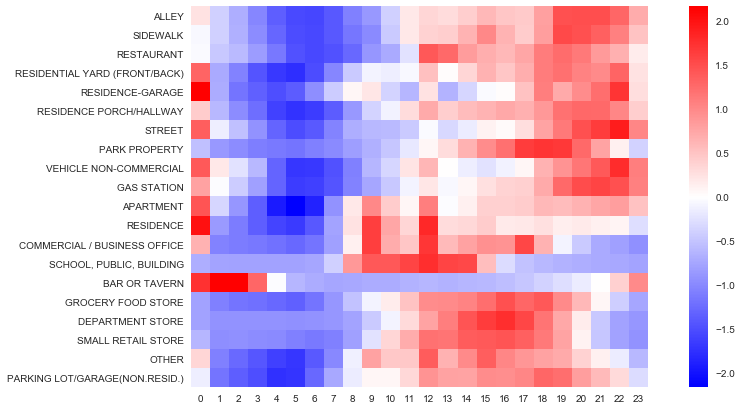

In [18]:
plt.figure(figsize=(15,7))
scale_and_plot(hour_by_location)


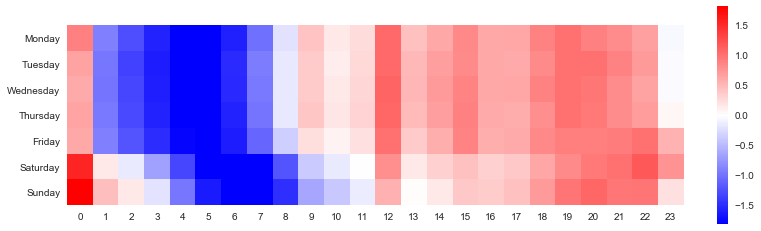

In [19]:
plt.figure(figsize=(12,4))
scale_and_plot(hour_by_week, ix=np.arange(7))


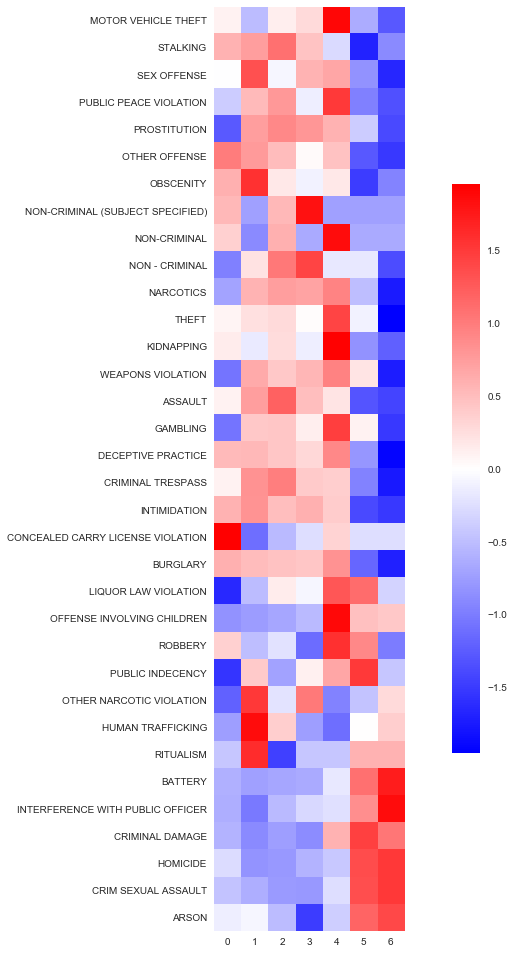

In [20]:
plt.figure(figsize=(17,17))
scale_and_plot(dayofweek_by_type)


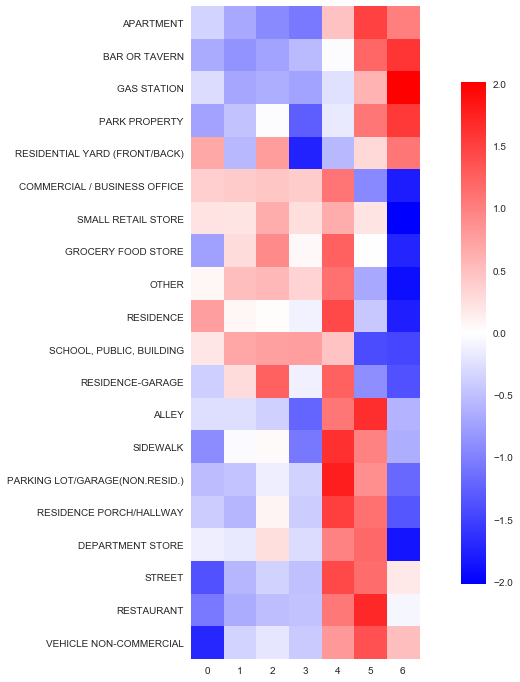

In [21]:
plt.figure(figsize=(15,12))
scale_and_plot(dayofweek_by_location)


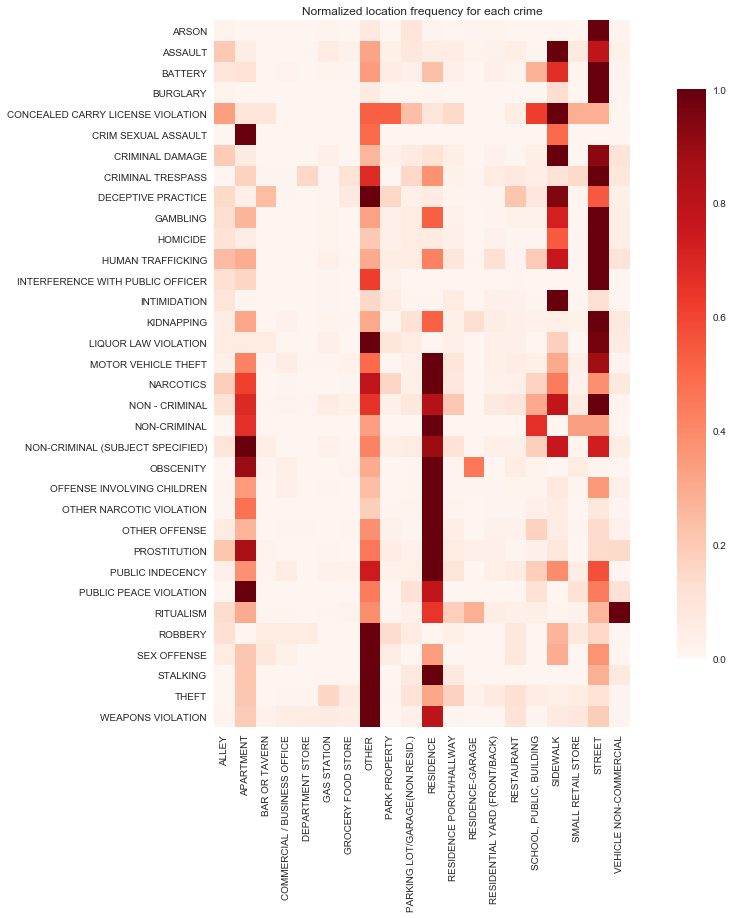

In [22]:
df = normalize(location_by_type)
ix = AC(3).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()